In [1]:
data_dir = '../../dataset/merfish_human_neocortex_SSL.h5ad'

In [2]:
import scanpy as sc

# 读取原始数据
adata = sc.read_h5ad(data_dir)
adata

AnnData object with n_obs × n_vars = 234125 × 300
    obs: 'Cell_ID', 'orig.ident', 'nCount_Vizgen', 'nFeature_Vizgen', 'z', 'volume', 'fov', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'Sample_ID', 'Estimated_postconceptional_age_in_days', 'Group', 'Region', 'Region_details', 'integrated_snn_res.2.8', 'class', 'subclass', 'type', 'nCount_niche', 'nFeature_niche', 'niches', 'niche_name', 'type_updated', 'x', 'y', 'cell_type', 'tissue', 'slice_id', 'cellcharter_scVI', 'cellcharter_SSL_BT_ZS', 'cellcharter_SSL_RM_ZS', 'STAGATE_SSL_BT_ZS', 'STAGATE_SSL_RM_ZS', 'STAGATE_original', 'cellcharter_SSL_BT_FT', 'cellcharter_SSL_RM_FT', 'STAGATE_SSL_BT_FT', 'STAGATE_SSL_RM_FT', 'cellcharter_BT_FT_42', 'STAGATE_RM_FT_42', 'STAGATE_BT_FT_42', 'STAGATE_BT_FT_761', 'STAGATE_BT_FT_9824', 'STAGATE_BT_ZS_476', 'STAGATE_BT_ZS_3407', 'STAGATE_RM_FT_761', 'STAGATE_RM_ZS_42', 'STAGATE_RM_ZS_476', 'STAGATE_RM_ZS_761', 'STAGATE_RM_ZS_3407', 'STAGATE_RM_ZS_9824', 'STAGATE_BT_FT_476', 'STAGATE_BT_FT_3407',

In [3]:
import os

from matplotlib import pyplot as plt

os.environ['NUMBA_NUM_THREADS'] = '15'
os.environ['MKL_NUM_THREADS']= '15'
os.environ['NUMEXPR_NUM_THREADS']='15'
os.environ['OMP_NUM_THREADS']='15'

import anndata as ad
from collections import defaultdict
import numpy as np
import pandas as pd
import scanpy as sc
import cellcharter as cc
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import squidpy as sq
import tracemalloc
import time





nhood_layers = 4





tracemalloc.start()
whole_time_start = time.time()

preprocess_time_start = time.time()

# 整合所有切片数据
adata.X = adata.raw.X.copy()



adata.layers["counts"] = adata.X.copy()


preprocess_time_cost = time.time() - preprocess_time_start


rng = np.random.default_rng(12345)
seeds = rng.integers(low=0, high=32768, size=1)
print(f'Seed: {seeds[0]}')

Seed: 22911


In [4]:
random_state=42


In [1]:
for i, seed in enumerate(seeds):

    represetntation_time_start = time.time()
    sq.gr.spatial_neighbors(adata, library_key='slice_id', coord_type='generic', delaunay=True, spatial_key='spatial', percentile=99)
    cc.gr.aggregate_neighbors(adata, n_layers=nhood_layers, use_rep=f'SSL_RM_ZS_{random_state}', out_key='X_cellcharter')
    represetntation_time_cost = time.time() - represetntation_time_start
    print(f'time cost for representation: {represetntation_time_cost}')
    
    
    clustering_time_start = time.time()
    model_params = {
            'random_state': random_state,
            'trainer_params': {
                'accelerator':'gpu',
                'enable_progress_bar': True
            },
        }
    
    autok = cc.tl.ClusterAutoK(
    n_clusters=(10,10), 
    max_runs=5,
    convergence_tol=0.001,
    model_params=model_params
    )
       
    autok.fit(adata, use_rep='X_cellcharter')
    adata.obs['cluster_cellcharter'] = autok.predict(adata, use_rep='X_cellcharter')
    clustering_time_cost = time.time() - clustering_time_start
    print(f'Time cost for clustering: {clustering_time_cost}')

    whole_time_cost = time.time() - whole_time_start
    # 获取内存使用的峰值
    current, peak = tracemalloc.get_traced_memory()
    peak_memory_mb = peak / (1024 * 1024)  # 将内存使用量从字节转换为MB
    tracemalloc.stop()
    print(f'Peak memory usage: {peak_memory_mb:.2f} MB')
    print(f'Time cost for whole run : {whole_time_cost}')

NameError: name 'seeds' is not defined

In [6]:

# 结果保存目录
output_dir = '../human_neocortex_SSL_RM_ZS_cellcharter_image'
os.makedirs(output_dir, exist_ok=True)
nmi_values = []
ari_values = []

def compute_nmi(adata, predict_key, ground_truth_key):
    return normalized_mutual_info_score(adata.obs[ground_truth_key], adata.obs[predict_key])

def compute_ari(adata, predict_key, ground_truth_key):
    return adjusted_rand_score(adata.obs[ground_truth_key], adata.obs[predict_key])

for batch in adata.obs['slice_id'].cat.categories:
    current_adata = adata[adata.obs['slice_id'] == batch]
    
    if 'tissue' in current_adata.obs:
        nmi = compute_nmi(adata=current_adata, predict_key='cluster_cellcharter', ground_truth_key='tissue')
        ari = compute_ari(adata=current_adata, predict_key='cluster_cellcharter', ground_truth_key='tissue')
        nmi = np.round(nmi, 3)
        ari = np.round(ari, 3)

        nmi_values.append(nmi)
        ari_values.append(ari)

        title = f'{batch}\n NMI: {nmi}  ARI: {ari}'
        print(title)
    else:
        title = f'{batch}'

    # 绘制以 cluster_cellcharter 标签着色的图像
    axes = sc.pl.embedding(adata=current_adata, basis='spatial', color='cluster_cellcharter', show=False)
    axes.axis('equal')
    axes.set_title(f'{title} (Cellcharter_SSL_RM_ZS)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'SSL_RM_ZS_embedding_Cellcharter_{batch}.png'), dpi=400)
    plt.savefig(os.path.join(output_dir, f'SSL_RM_ZS_embedding_Cellcharter_{batch}.eps'), dpi=400)
    plt.close()
# 保存到当前目录下名为 results 的文件夹中
# 当前 Notebook 文件名和实验名称
notebook_name = "random_mask_zero_shot_cellcharter_MERSCOPE_human_neocortex_42.ipynb"
experiment_name = "random_mask_zero_shot_cellcharter_MERSCOPE_human_neocortex_42"

if not os.path.exists('results'):
    os.makedirs('results')

# 定义 CSV 文件的路径
csv_filename = f"results/{experiment_name}_results.csv"

# 保存 Batch, NMI, ARI, 和 experiment_name 到 CSV 文件中
import csv
with open(csv_filename, 'a', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    # 如果文件是新建的，写入表头
    if os.stat(csv_filename).st_size == 0:
        writer.writerow(['Experiment Name', 'Batch', 'NMI', 'ARI'])
    writer.writerow([experiment_name, batch, nmi, ari])


ARKFrozen-62-PFC
 NMI: 0.597  ARI: 0.467


/home/hanchuangyi/miniconda3/envs/cellcharter/lib/python3.10/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


NIH-4365-BA10
 NMI: 0.562  ARI: 0.526


/home/hanchuangyi/miniconda3/envs/cellcharter/lib/python3.10/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


NIH-4392-BA17
 NMI: 0.124  ARI: 0.034


/home/hanchuangyi/miniconda3/envs/cellcharter/lib/python3.10/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


NIH-5900-BA17
 NMI: 0.508  ARI: 0.36


/home/hanchuangyi/miniconda3/envs/cellcharter/lib/python3.10/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


UCSF2018-003-MFG
 NMI: 0.683  ARI: 0.784


/home/hanchuangyi/miniconda3/envs/cellcharter/lib/python3.10/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


<Axes: title={'center': 'cluster_cellcharter'}, xlabel='spatial1', ylabel='spatial2'>

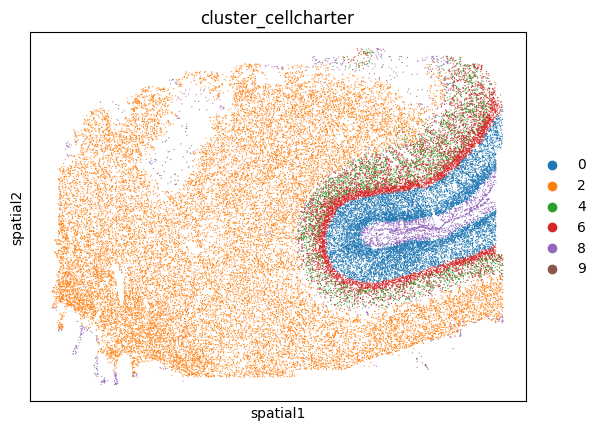

In [7]:
sc.pl.embedding(adata=current_adata, basis='spatial', color='cluster_cellcharter', show=False)

In [8]:
new_adata = sc.read_h5ad(data_dir)
new_adata.obs[f'cellcharter_RM_ZS_{random_state}'] = adata.obs['cluster_cellcharter']
new_adata.obsm[f'cellcharter_RM_ZS_{random_state}'] = adata.obsm['X_cellcharter']
new_adata

AnnData object with n_obs × n_vars = 234125 × 300
    obs: 'Cell_ID', 'orig.ident', 'nCount_Vizgen', 'nFeature_Vizgen', 'z', 'volume', 'fov', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'Sample_ID', 'Estimated_postconceptional_age_in_days', 'Group', 'Region', 'Region_details', 'integrated_snn_res.2.8', 'class', 'subclass', 'type', 'nCount_niche', 'nFeature_niche', 'niches', 'niche_name', 'type_updated', 'x', 'y', 'cell_type', 'tissue', 'slice_id', 'cellcharter_scVI', 'cellcharter_SSL_BT_ZS', 'cellcharter_SSL_RM_ZS', 'STAGATE_SSL_BT_ZS', 'STAGATE_SSL_RM_ZS', 'STAGATE_original', 'cellcharter_SSL_BT_FT', 'cellcharter_SSL_RM_FT', 'STAGATE_SSL_BT_FT', 'STAGATE_SSL_RM_FT', 'cellcharter_BT_FT_42', 'STAGATE_RM_FT_42', 'STAGATE_BT_FT_42', 'STAGATE_BT_FT_761', 'STAGATE_BT_FT_9824', 'STAGATE_BT_ZS_476', 'STAGATE_BT_ZS_3407', 'STAGATE_RM_FT_761', 'STAGATE_RM_ZS_42', 'STAGATE_RM_ZS_476', 'STAGATE_RM_ZS_761', 'STAGATE_RM_ZS_3407', 'STAGATE_RM_ZS_9824', 'STAGATE_BT_FT_476', 'STAGATE_BT_FT_3407',

In [9]:
new_adata.write_h5ad(data_dir)